In [7]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import sklearn.metrics as metrics
import sklearn.linear_model as sklm
import matplotlib.pyplot as plt

In [8]:
# Pull in remote dataset from UCI ML repo
raw_data = fetch_ucirepo(id=849)

In [9]:
# Create flat table
raw_df: pd.DataFrame = raw_data.data.features.merge(raw_data.data.targets,
                                                    how='outer',
                                                    left_index=True,
                                                    right_index=True)

# Relabeling with friendly column headers
new_colnames = ["datetime",
                "temperature",
                "humidity",
                "wind_speed",
                "general_diffuse_flows",
                "diffuse_flows",
                "zone_1_power",
                "zone_2_power",
                "zone_3_power"]

colname_updates = {orig_colnames: new_colnames for orig_colnames,
                   new_colnames in zip(raw_df.columns, new_colnames)}

tetoun_power: pd.DataFrame = raw_df.rename(columns=colname_updates)

# Feature Engineering
tetoun_power["datetime"] = pd.to_datetime(tetoun_power["datetime"])

tetoun_power["total_power"] = tetoun_power["zone_1_power"] + \
    tetoun_power["zone_2_power"] + tetoun_power["zone_3_power"]

tetoun_power = tetoun_power.assign(
    year=tetoun_power["datetime"].dt.year,
    month=tetoun_power["datetime"].dt.month,
    day=tetoun_power["datetime"].dt.day,
    hour=tetoun_power["datetime"].dt.hour,
    minute=tetoun_power["datetime"].dt.minute,
    day_of_week=tetoun_power["datetime"].dt.dayofweek,
    day_of_year=tetoun_power["datetime"].dt.dayofyear,
    weekofyear=tetoun_power["datetime"].dt.isocalendar().week,
    zone_1_2wma=tetoun_power["zone_1_power"].rolling(window=72).mean(),
    zone_1_1mma=tetoun_power["zone_1_power"].rolling(window=144).mean(),
    zone_1_2mma=tetoun_power["zone_1_power"].rolling(window=288).mean(),
    zone_1_3mma=tetoun_power["zone_1_power"].rolling(window=432).mean(),
    zone_1_6mma=tetoun_power["zone_1_power"].rolling(window=864).mean(),
    zone_2_6mma=tetoun_power["zone_2_power"].rolling(window=864).mean(),
    zone_3_6mma=tetoun_power["zone_3_power"].rolling(window=864).mean(),
    total_power_6mma=tetoun_power["total_power"].rolling(window=864).mean()
)

In [10]:
tetoun_power.head()

,datetime,temperature,humidity,wind_speed,general_diffuse_flows,diffuse_flows,zone_1_power,zone_2_power,zone_3_power,total_power,...,day_of_year,weekofyear,zone_1_2wma,zone_1_1mma,zone_1_2mma,zone_1_3mma,zone_1_6mma,zone_2_6mma,zone_3_6mma,total_power_6mma
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,70425.53544,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,69320.84387,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,67803.22193,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,65489.23209,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,63650.44627,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
tetoun_power.loc[tetoun_power["month"] == 1].shape[0]/31/2

72.0

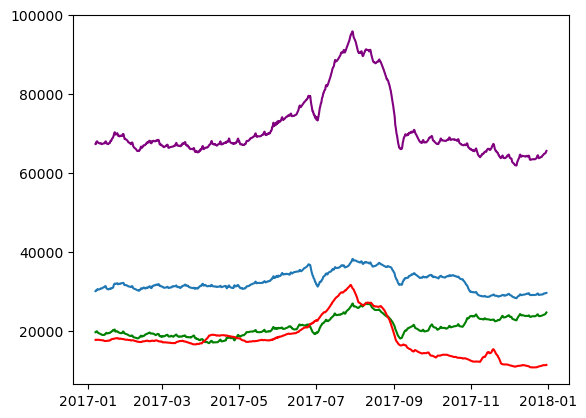

In [12]:
fig, ax = plt.subplots()

ax.plot(tetoun_power["datetime"], tetoun_power["zone_1_6mma"])
ax.plot(tetoun_power["datetime"], tetoun_power["zone_2_6mma"], color="green")
ax.plot(tetoun_power["datetime"], tetoun_power["zone_3_6mma"], color="red")
ax.plot(tetoun_power["datetime"],
        tetoun_power["total_power_6mma"], color="purple")

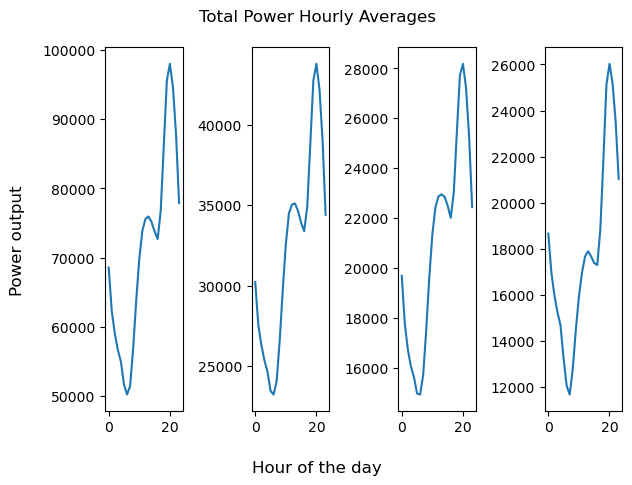

In [13]:
tp_hourly_avg = tetoun_power.groupby("hour").agg({"total_power": "mean"})
z1_hourly_avg = tetoun_power.groupby("hour").agg({"zone_1_power": "mean"})
z2_hourly_avg = tetoun_power.groupby("hour").agg({"zone_2_power": "mean"})
z3_hourly_avg = tetoun_power.groupby("hour").agg({"zone_3_power": "mean"})

fig, ax = plt.subplots(1, 4)

ax[0].plot(np.arange(0, 24, 1), tp_hourly_avg["total_power"])
ax[1].plot(np.arange(0, 24, 1), z1_hourly_avg["zone_1_power"])
ax[2].plot(np.arange(0, 24, 1), z2_hourly_avg["zone_2_power"])
ax[3].plot(np.arange(0, 24, 1), z3_hourly_avg["zone_3_power"])

fig.suptitle("Total Power Hourly Averages")
fig.supylabel("Power output")
fig.supxlabel("Hour of the day")
fig.tight_layout()
plt.show()

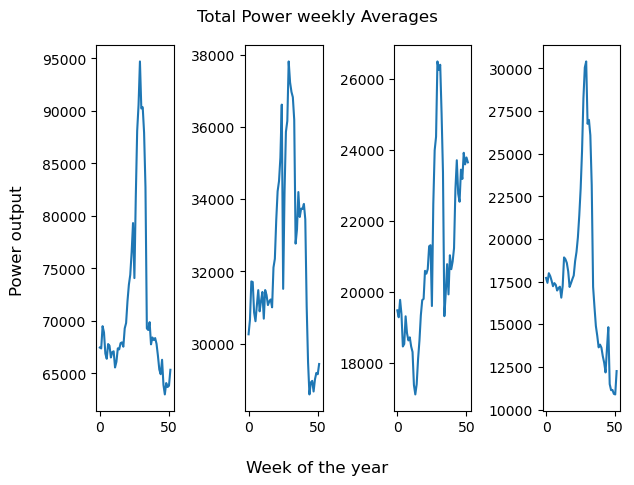

In [14]:
tp_weekly_avg = tetoun_power.groupby("weekofyear").agg({"total_power": "mean"})
z1_weekly_avg = tetoun_power.groupby(
    "weekofyear").agg({"zone_1_power": "mean"})
z2_weekly_avg = tetoun_power.groupby(
    "weekofyear").agg({"zone_2_power": "mean"})
z3_weekly_avg = tetoun_power.groupby(
    "weekofyear").agg({"zone_3_power": "mean"})

fig, ax = plt.subplots(1, 4)

ax[0].plot(np.arange(0, 52, 1), tp_weekly_avg["total_power"])
ax[1].plot(np.arange(0, 52, 1), z1_weekly_avg["zone_1_power"])
ax[2].plot(np.arange(0, 52, 1), z2_weekly_avg["zone_2_power"])
ax[3].plot(np.arange(0, 52, 1), z3_weekly_avg["zone_3_power"])

fig.suptitle("Total Power weekly Averages")
fig.supylabel("Power output")
fig.supxlabel("Week of the year")
fig.tight_layout()
plt.show()

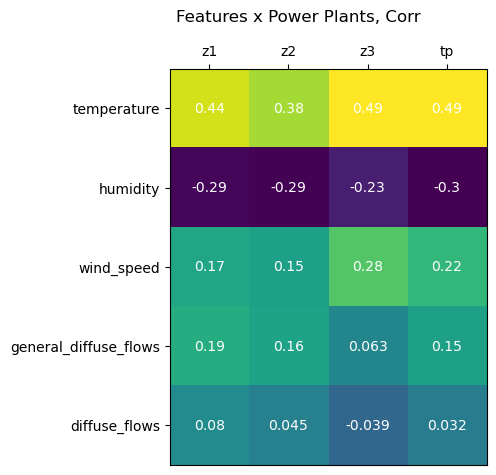

In [15]:
common_feats = ["temperature",
                "humidity",
                "wind_speed",
                "general_diffuse_flows",
                "diffuse_flows"]

tp_corr = tetoun_power[common_feats+["total_power"]] \
    .corr().loc[pd.Index(common_feats), "total_power"]

z1_corr = tetoun_power[common_feats+["zone_1_power"]] \
    .corr().loc[pd.Index(common_feats), "zone_1_power"]

z2_corr = tetoun_power[common_feats+["zone_2_power"]] \
    .corr().loc[pd.Index(common_feats), "zone_2_power"]

z3_corr = tetoun_power[common_feats+["zone_3_power"]] \
    .corr().loc[pd.Index(common_feats), "zone_3_power"]

corr_df = pd.DataFrame({"z1": z1_corr, "z2": z2_corr,
                       "z3": z3_corr, "tp": tp_corr})

fig, ax = plt.subplots()

ax.imshow(corr_df)

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xticks(np.arange(corr_df.shape[1]), labels=corr_df.columns)
ax.set_yticks(np.arange(corr_df.shape[0]), labels=common_feats)

# Loop over data dimensions and create text annotations.
for i in range(corr_df.shape[0]):
    for j in range(corr_df.shape[1]):
        text = ax.text(j, i, f"{corr_df.iloc[i, j]:.2}",
                       ha="center", va="center", color="w")

plt.suptitle("Features x Power Plants, Corr")
plt.tight_layout()
plt.show()

The table above explores basic correlations between the predictors and each of the power zones as well as with the combination of all three zones.

Without additional analysis, it appears that zones 1 and 2 are most similar to eachother and have a greater impact on the total output than Zone 3.

In [16]:
# Dataframe of Cosine Similarities
cs_df = pd.DataFrame(metrics.pairwise.cosine_similarity(corr_df.T))
cs_df.columns = ["z1", "z2", "z3", "tp"]
cs_df.index = ["z1", "z2", "z3", "tp"]

cs_df

,z1,z2,z3,tp
z1,1.000000,0.995680,0.935337,0.990414
z2,0.995680,1.000000,0.936256,0.990187
z3,0.935337,0.936256,1.000000,0.974533
tp,0.990414,0.990187,0.974533,1.000000


In [17]:
tetoun_power[["zone_1_power", "zone_2_power",
              "zone_3_power", "total_power"]].corr()

,zone_1_power,zone_2_power,zone_3_power,total_power
zone_1_power,1.000000,0.834519,0.750733,0.959146
zone_2_power,0.834519,1.000000,0.570932,0.871069
zone_3_power,0.750733,0.570932,1.000000,0.871777
total_power,0.959146,0.871069,0.871777,1.000000


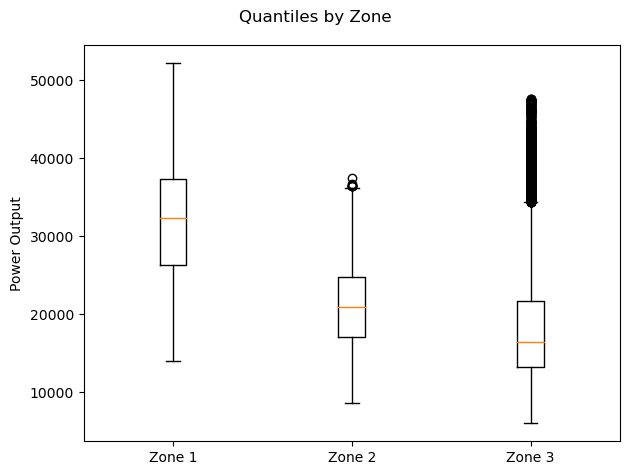

In [18]:
fig, ax = plt.subplots()

ax.boxplot(tetoun_power["zone_1_power"], positions=[1])
ax.boxplot(tetoun_power["zone_2_power"], positions=[2])
ax.boxplot(tetoun_power["zone_3_power"], positions=[3])

ax.set_xticklabels(["Zone 1", "Zone 2", "Zone 3"])
ax.set_ylabel("Power Output")

fig.suptitle("Quantiles by Zone")
fig.tight_layout()
plt.show()

In [19]:
tetoun_power.columns

Index(['datetime', 'temperature', 'humidity', 'wind_speed',
       'general_diffuse_flows', 'diffuse_flows', 'zone_1_power',
       'zone_2_power', 'zone_3_power', 'total_power', 'year', 'month', 'day',
       'hour', 'minute', 'day_of_week', 'day_of_year', 'weekofyear',
       'zone_1_2wma', 'zone_1_1mma', 'zone_1_2mma', 'zone_1_3mma',
       'zone_1_6mma', 'zone_2_6mma', 'zone_3_6mma', 'total_power_6mma'],
      dtype='object')

In [48]:
# Multiple Linear Regression: Zone 1
mv_lm_zone_1 = smf.ols(formula="zone_1_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                       data=tetoun_power).fit()


# Multiple Linear Regression: Zone 2
mv_lm_zone_2 = smf.ols(formula="zone_2_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                       data=tetoun_power).fit()


# Multiple Linear Regression: Zone 3
mv_lm_zone_3 = smf.ols(formula="zone_3_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                       data=tetoun_power).fit()

# Multiple Linear Regression: Total Power
mv_lm_total_power = smf.ols(formula="total_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                       data=tetoun_power).fit()

print(mv_lm_zone_1.summary2())

                        Results: Ordinary least squares
Model:                  OLS                 Adj. R-squared:        0.644       
Dependent Variable:     zone_1_power        AIC:                   1024697.0003
Date:                   2024-10-15 21:16    BIC:                   1024776.8030
No. Observations:       52416               Log-Likelihood:        -5.1234e+05 
Df Model:               8                   F-statistic:           1.186e+04   
Df Residuals:           52407               Prob (F-statistic):    0.00        
R-squared:              0.644               Scale:                 1.8097e+07  
-------------------------------------------------------------------------------
                        Coef.    Std.Err.    t     P>|t|    [0.025     0.975]  
-------------------------------------------------------------------------------
Intercept             18313.9454 152.3441 120.2144 0.0000 18015.3496 18612.5412
month                  -253.2628   5.7887 -43.7515 0.0000  -264.

In [43]:
print(mv_lm_zone_2.summary2())

                        Results: Ordinary least squares
Model:                   OLS                 Adj. R-squared:        0.594      
Dependent Variable:      zone_2_power        AIC:                   998474.7431
Date:                    2024-10-15 21:12    BIC:                   998554.5458
No. Observations:        52416               Log-Likelihood:        -4.9923e+05
Df Model:                8                   F-statistic:           9603.      
Df Residuals:            52407               Prob (F-statistic):    0.00       
R-squared:               0.594               Scale:                 1.0974e+07 
-------------------------------------------------------------------------------
                        Coef.    Std.Err.    t     P>|t|    [0.025     0.975]  
-------------------------------------------------------------------------------
Intercept             13679.7751 118.6295 115.3151 0.0000 13447.2601 13912.2901
month                   406.3028   4.5076  90.1371 0.0000   397.

In [46]:
print(mv_lm_zone_3.summary2())

                       Results: Ordinary least squares
Model:                  OLS                Adj. R-squared:       0.601       
Dependent Variable:     zone_3_power       AIC:                  1022897.6753
Date:                   2024-10-15 21:14   BIC:                  1022977.4780
No. Observations:       52416              Log-Likelihood:       -5.1144e+05 
Df Model:               8                  F-statistic:          9880.       
Df Residuals:           52407              Prob (F-statistic):   0.00        
R-squared:              0.601              Scale:                1.7487e+07  
-----------------------------------------------------------------------------
                        Coef.   Std.Err.     t     P>|t|    [0.025    0.975] 
-----------------------------------------------------------------------------
Intercept             5947.5687 149.7516   39.7162 0.0000 5654.0542 6241.0831
month                 -871.3437   5.6902 -153.1316 0.0000 -882.4965 -860.1909
day_of_we

In [49]:
print(mv_lm_total_power.summary())

                            OLS Regression Results                            
Dep. Variable:            total_power   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                 1.133e+04
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        21:16:54   Log-Likelihood:            -5.5908e+05
No. Observations:               52416   AIC:                         1.118e+06
Df Residuals:                   52407   BIC:                         1.118e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              3.794e+

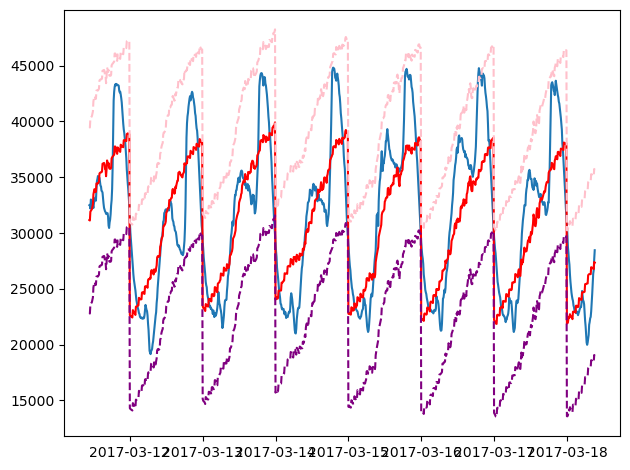

In [21]:
sample = tetoun_power[10000:11000]

# pred = mv_lm_zone_1.predict(sample)
pred = mv_lm_zone_1.get_prediction(sample).summary_frame()

fig, ax = plt.subplots()

ax.plot(sample["datetime"], sample["zone_1_power"])
ax.plot(sample["datetime"], pred["mean"], color="red")
ax.plot(sample["datetime"], pred["obs_ci_lower"],
        linestyle='--', color="purple")
ax.plot(sample["datetime"], pred["obs_ci_upper"], linestyle='--', color="pink")

fig.tight_layout()

plt.show()

In [22]:
# Accuracy measures for Zone 1 MV LM
metrics.mean_absolute_percentage_error(tetoun_power["zone_1_power"],
                                       mv_lm_zone_1.predict(tetoun_power))

0.10842811026307293

In [23]:
# Fitting a Ridge Regression
y = tetoun_power["zone_1_power"]
X = tetoun_power[["month", "day_of_week", "hour", "temperature",
                  "humidity", "wind_speed", "general_diffuse_flows", "diffuse_flows"]]

z1_rr = sklm.RidgeCV(alphas=list(np.linspace(100, 1000, num=10000))).fit(X, y)
# z1_rr = sklm.RidgeCV(alphas=[1.0e-3]).fit(X, y)

z1_rr.score(X, y)


0.6441247837446175

In [24]:
# Learned Regularization parameter
z1_rr.alpha_

315.66156615661566

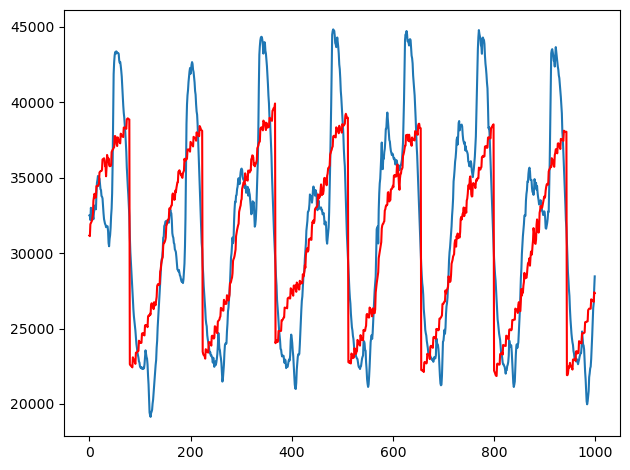

In [25]:
sample = X[10000:11000]

# pred = mv_lm_zone_1.predict(sample)
pred = z1_rr.predict(sample)
output_space = np.linspace(0,  999, num=1000)

fig, ax = plt.subplots()

ax.plot(output_space, tetoun_power.loc[10000:10999, "zone_1_power"])
ax.plot(output_space, pred, color="red")

fig.tight_layout()

plt.show()

In [34]:
# Calculate the log-likelihood
def log_likelihood(model, y, X):
    k = len(model.coef_) + 1 
    n = len(y)

    residuals = y - model.predict(X)
    mse = metrics.mean_squared_error(y, model.predict(X))
    return k, -n/2 * np.log(2*np.pi) - n/2 * np.log(mse) - 1/(2*mse) * np.sum(residuals**2)

def aic(model, y, X):
    k, ll = log_likelihood(model, y, X)
    return 2*k - 2*ll

In [35]:
# Comparing AIC

print(f"AIC RR: {aic(z1_rr, y, X)}")
print(f"AIC MVLM: {mv_lm_zone_1.aic}")



AIC RR: 1024697.0046720345
AIC MVLM: 1024697.000258856


In [61]:
pred_zone_sums = \
    mv_lm_zone_1.predict(tetoun_power) + \
    mv_lm_zone_1.predict(tetoun_power) + \
    mv_lm_zone_1.predict(tetoun_power)

pred_tp = mv_lm_total_power.predict(tetoun_power)

print(metrics.mean_absolute_percentage_error(tetoun_power["total_power"],
                                             pred_zone_sums))

print(metrics.mean_absolute_percentage_error(tetoun_power["total_power"],
                                             pred_tp))

print()
print(metrics.explained_variance_score(tetoun_power["total_power"],
                                       pred_zone_sums))

print(metrics.explained_variance_score(tetoun_power["total_power"],
                                       pred_tp))

print()
print(np.sqrt(metrics.mean_squared_error(tetoun_power["total_power"],
                                         pred_zone_sums)))

print(np.sqrt(metrics.mean_squared_error(tetoun_power["total_power"],
                                         pred_tp)))

0.3980473224893339
0.11916965346437886

0.5766902339452555
0.633633488304588

28118.741640566117
10376.33746079026
